In [1]:
import sys
sys.path.insert(0, '../')
from gw_tools.gw_plot import gw_plot
from gw_tools import data_prep
from gw_tools.gw_LSTM import gw_LSTM
import datetime
import IPython
import IPython.display
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time

2023-11-22 12:15:36.239125: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 12:15:36.272334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 12:15:36.272357: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 12:15:36.272385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 12:15:36.278507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 12:15:36.278881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
df = data_prep.select_features(pd.read_pickle('../data/pickled_data/AFL259_short.pkl'))
df = data_prep.add_toy_signal(df).set_index('date')

TEST_SIZE = 365 # size of the test set 

X_train = df[:-TEST_SIZE].copy()
X_test = df[-TEST_SIZE:].copy()

y_train = X_train.avg_well_depth.copy().values
y_test = X_test.avg_well_depth.copy().values

well_tr_mean = np.mean(X_train.avg_well_depth.values)
well_tr_std = np.std(X_train.avg_well_depth.values)

In [3]:
scaler =  StandardScaler(copy=True)

#some small parameters, we're just checking that the class works
gw_LSTM = gw_LSTM(WINDOW_SIZE=6,
                 LSTM_UNITS=64,
                 NUM_FEATS=12,
                 D_MAX_LAYERS = 1, D_TOP_UNITS = 8, D_MIN_UNITS=2,
                 D_UNIT_SCALE = 0.5,
                 LEARNING_RATE=0.01, 
                 EPOCHS=20, 
                 RANDOM_STATE = 90210,
                 CHECKPOINT = False,
                 tmean = well_tr_mean,
                 tsd = well_tr_std)

## Prepare the pipeline
pipe = Pipeline([('scaler', scaler), 
                     ('gw_LSTM', gw_LSTM)])

In [4]:
## Training on the whole data set   
pipe.fit(X_train,y_train)

## Making a prediction on the holdout set
pred = pipe.predict(X_test)

score = np.sqrt(np.mean((y_test - pred)**2))

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

Epoch 1/20
124/124 [==============================] - 2s 2ms/step - loss: 1247.3171 - root_mean_squared_error: 35.3174
Epoch 2/20
124/124 [==============================] - 0s 2ms/step - loss: 10.9391 - root_mean_squared_error: 3.3074
Epoch 3/20
124/124 [==============================] - 0s 2ms/step - loss: 9.7625 - root_mean_squared_error: 3.1245
Epoch 4/20
124/124 [==============================] - 0s 2ms/step - loss: 6.5911 - root_mean_squared_error: 2.5673
Epoch 5/20
124/124 [==============================] - 0s 2ms/step - loss: 1.5333 - root_mean_squared_error: 1.2383
Epoch 6/20
124/124 [==============================] - 0s 2ms/step - loss: 0.8637 - root_mean_squared_error: 0.9294
Epoch 7/20
124/124 [==============================] - 0s 2ms/step - loss: 0.6535 - root_mean_squared_error: 0.8084
Epoch 8/20
124/124 [==============================] - 0s 2ms/step - loss: 0.4598 - root_mean_squared_error: 0.6781
Epoch 9/20
124/124 [==============================] - 0s 2ms/step - loss: 0

/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/meredith/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step





 This model has a root mean square error of 1.3541459355282806 when evaluated on the holdout data


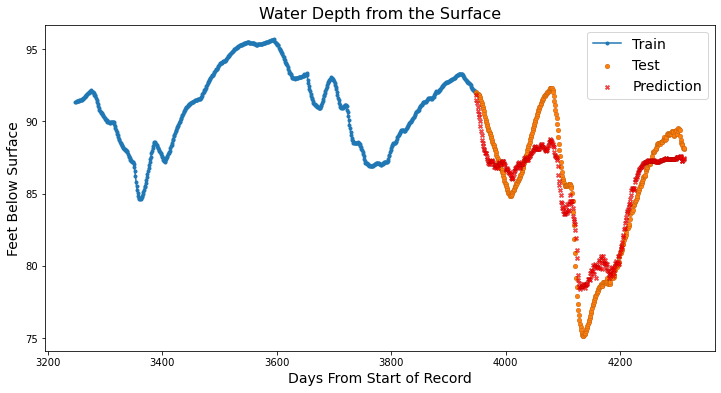

In [5]:
print('\n\n\n',f'This model has a root mean square error of {np.sqrt(score)} when evaluated on the holdout data')

gw_plot(train = y_train, test = y_test, pred = pred,train_limit=700)